In [ ]:
channels = ["3.16 Hz", "5.62 Hz", "10 Hz", "17.6 Hz",
            "31.6 Hz", "56.2 Hz", "100 Hz", "176 Hz",
            "316 Hz", "562 Hz", "1 kHz", '1.76 kHz',
            "3.16 kHz", "5.62 kHz", "10.0 kHz", "17.6 kHz"]

In [1]:
import pyspedas, pytplot, load
from pytplot import get_data
import numpy as np
trange = ['1990-02-11', '1990-02-12']
load.mca(trange)
tplot_names = ['Emax', 'Eave', 'Bmax', 'Bave']
for i in range(4):
    tplot_variable = pytplot.get_data(tplot_names[i])
    tplot_variable_float = (tplot_variable.y).astype(float)
    np.place(tplot_variable_float, tplot_variable_float == 254, np.nan)
    tplot_variable_0dB = 1e-6 #mV or pT
    bandwidth = tplot_variable.v * 0.3
    tplot_variable_amplitude = (10**(tplot_variable_float/20)) * (tplot_variable_0dB)  / np.sqrt(bandwidth)
    tplot_variable_power = (10**(tplot_variable_float/10)) * ((tplot_variable_0dB)**2)  / bandwidth
    pytplot.store_data(tplot_names[i] +'_Amp', data={'x': tplot_variable.times, 'y': tplot_variable_amplitude, 'v': tplot_variable.v})
    pytplot.store_data(tplot_names[i] +'_Pwr', data={'x': tplot_variable.times, 'y': tplot_variable_power, 'v': tplot_variable.v})
Emax = pytplot.get_data('Emax_Amp')
Bmax = pytplot.get_data('Bmax_Amp')

'''
#Time interpolate
try:
    pyspedas.tinterpol('akb_ILAT', interp_to='Emax_Pwr', newname = 'ILAT')
except:
    with open('./akebono_orbit_error_day_list.txt', mode="a") as f:
        f.write(trange[0] + '\n')
        print('orbit file is not perfect')
       
    pyspedas.tinterpol('akb_MLAT', interp_to='Emax_Pwr', newname = 'MLAT')
    pyspedas.tinterpol('akb_Pass', interp_to='Emax_Pwr', newname = 'Pass', method = 'nearest')
    pyspedas.tinterpol('akb_ALT', interp_to='Emax_Pwr', newname = 'ALT')
    pyspedas.tinterpol('akb_MLT', interp_to='Emax_Pwr', newname = 'MLT', method = 'nearest')
    #Limit ILAT range
    Emax = get_data('Emax_Pwr')
    time = Emax.times
    ILAT = get_data('ILAT')
    ILAT = ILAT.y
    MLAT = get_data('MLAT')
    MLAT = MLAT.y
    MLT = get_data('MLT')
    MLT = MLT.y

    north_index_tuple = np.where((MLAT>0) & (ILAT>ILAT_min)) 
    south_index_tuple = np.where((MLAT<0) & (ILAT>ILAT_min))

    north_index = north_index_tuple[0]
    south_index = south_index_tuple[0]


    #make start_time list, end_time list
    if len(north_index) == 0:
        north_start_time_list = None
        north_end_time_list = None
    else:    
        north_start_time_index = [north_index[0]]
        north_end_time_index = []
        for i in range(north_index.size-1):
            if north_index[i+1] - north_index[i] > 1:
                north_end_time_index.append(north_index[i])
                north_start_time_index.append(north_index[i+1])
                
        north_end_time_index.append(north_index[-1])

        north_start_time_index = np.array(north_start_time_index)
        north_end_time_index = np.array(north_end_time_index)

        north_start_time_list = pyspedas.time_string(time[north_start_time_index], fmt='%Y-%m-%d %H:%M:%S')
        north_end_time_list = pyspedas.time_string(time[north_end_time_index], fmt='%Y-%m-%d %H:%M:%S')

    if len(south_index) == 0:
        south_start_time_list = None
        south_end_time_list = None
    else:
        south_start_time_index = [south_index[0]]
        south_end_time_index = []
        for i in range(south_index.size-1):
            if south_index[i+1] - south_index[i] > 1:
                south_end_time_index.append(south_index[i])
                south_start_time_index.append(south_index[i+1])
                
        south_end_time_index.append(south_index[-1])

        south_start_time_index = np.array(south_start_time_index)
        south_end_time_index = np.array(south_end_time_index)

        south_start_time_list = pyspedas.time_string(time[south_start_time_index], fmt='%Y-%m-%d %H:%M:%S')
        south_end_time_list = pyspedas.time_string(time[south_end_time_index], fmt='%Y-%m-%d %H:%M:%S')


    start_time_list_list = [north_start_time_list, south_start_time_list]
    end_time_list_list = [north_end_time_list, south_end_time_list]
'''
time = Emax.times
slice_time = pyspedas.time_double('1990-02-11 18:05:30')
for i in range(time.size):
    if time[i] < slice_time:
        pass
    else:
        slice_time_index = i
        slice_time = time[i]
        break
Emax_slice = Emax.y[slice_time_index]
Bmax_slice = Bmax.y[slice_time_index]
freq_range = Emax.v



25-Jul-22 22:36:13: /usr/local/lib/python3.8/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),



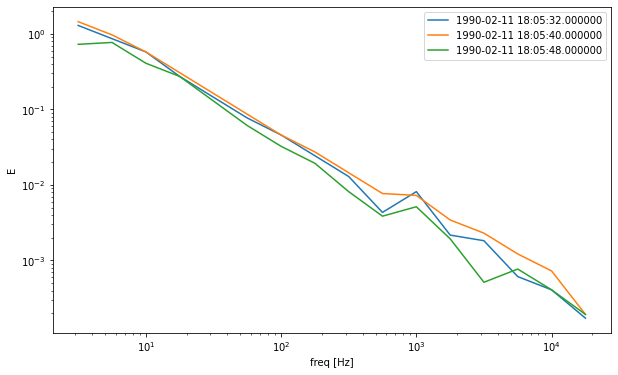

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
for i in range(3):
    plt.plot(freq_range, Emax.y[slice_time_index + i], label = pyspedas.time_string(time[slice_time_index + i]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('freq [Hz]')
plt.ylabel('E')

plt.legend()

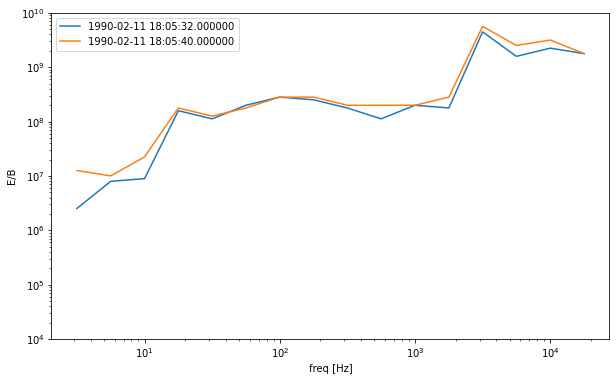

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
for i in range(2):
    plt.plot(freq_range, Emax.y[slice_time_index + i]/Bmax.y[slice_time_index + i] *1e9, label = pyspedas.time_string(time[slice_time_index + i]))
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e4, 1e10)
plt.xlabel('freq [Hz]')
plt.ylabel('E/B')

plt.legend()
plt.savefig("output2")

In [8]:
import numpy as np

a = np.array([0, 5, 2, np.nan, 5])
maxIndex = [i for i, x in enumerate(a) if x == np.nanmax(a)]
print(maxIndex)    # [1, 4]

[1, 4]


In [30]:
import pyspedas
import pytplot
from pytplot import get_data, store_data
import numpy as np
from load import mca, orb
import matplotlib.pyplot as plt

ILAT_min = 55
start_day_string = '1990-01-05'
start_day_time_double = pyspedas.time_double(start_day_string)
days = 180

seconds_per_day = 86400
day_list = []
for i in range(0, days+1):
    time_double = start_day_time_double + i * seconds_per_day
    day_list.append(pyspedas.time_string(time_double, fmt='%Y-%m-%d %H:%M:%S'))

Emax_pwr_10Hz_array = np.empty((0,0), float)
Emax_amp_176Hz_array = np.empty((0,0), float)
Emax_amp_316Hz_array = np.empty((0,0), float)
Emax_amp_562Hz_array = np.empty((0,0), float)

Bmax_amp_176Hz_array = np.empty((0,0), float)
Bmax_amp_316Hz_array = np.empty((0,0), float)
Bmax_amp_562Hz_array = np.empty((0,0), float)

E_to_B_176Hz_array = np.empty((0,0), float)
E_to_B_316Hz_array = np.empty((0,0), float)
E_to_B_562Hz_array = np.empty((0,0), float)

Emax_pwr_mean_fcH_fLH_array = np.empty((0,0), float)

for k in range(len(day_list)-1):
    
    trange = [day_list[k], day_list[k+1]]
    print(trange)
    try:
        mca(trange= trange)
    except Exception as e:
        print(e)
        continue
    try:
        orb(trange= trange)
    except Exception as e:
        print(e)
        #with open('./akebono_orbit_error_day_list.txt', mode="a") as f:
        #       f.write(trange[0] + '\n')
        
        #print('orbit file does not exists')
        continue
    
    tplot_names = pytplot.tplot_names(True)

    #dB to amplitude
    for i in range(4):
        tplot_variable = pytplot.get_data(tplot_names[i])
        tplot_variable_float = (tplot_variable.y).astype(float)
        np.place(tplot_variable_float, tplot_variable_float == 254, np.nan)
        tplot_variable_0dB = 1e-6 #mV or pT
        bandwidth = tplot_variable.v * 0.3
        tplot_variable_amplitude = (10**(tplot_variable_float/20)) * (tplot_variable_0dB)
        tplot_variable_power = (10**(tplot_variable_float/10)) * ((tplot_variable_0dB)**2) 
        pytplot.store_data(tplot_names[i] +'_Amp', data={'x': tplot_variable.times, 'y': tplot_variable_amplitude, 'v': tplot_variable.v})
        pytplot.store_data(tplot_names[i] +'_Pwr', data={'x': tplot_variable.times, 'y': tplot_variable_power, 'v': tplot_variable.v})
    
    #Time interpolate
    try:
        pyspedas.tinterpol('akb_ILAT', interp_to='Emax_Pwr', newname = 'ILAT')
    except:
        #with open('./akebono_orbit_error_day_list.txt', mode="a") as f:
        #       f.write(trange[0] + '\n')
        print('orbit file is not perfect')
        continue
    pyspedas.tinterpol('akb_MLAT', interp_to='Emax_Pwr', newname = 'MLAT')
    pyspedas.tinterpol('akb_Pass', interp_to='Emax_Pwr', newname = 'Pass', method = 'nearest')
    pyspedas.tinterpol('akb_ALT', interp_to='Emax_Pwr', newname = 'ALT')
    pyspedas.tinterpol('akb_MLT', interp_to='Emax_Pwr', newname = 'MLT', method = 'nearest')
    #Limit ILAT range
    Emax = get_data('Emax_Pwr')
    time = Emax.times
    ILAT = get_data('ILAT')
    ILAT = ILAT.y
    MLAT = get_data('MLAT')
    MLAT = MLAT.y
    MLT = get_data('MLT')
    MLT = MLT.y

    Emax_pwr = get_data('Emax_Pwr')
    Emax_amp = get_data('Emax_Amp')
    Bmax_amp = get_data('Bmax_Amp')
    
    E_to_B = Emax_amp.y/Bmax_amp.y *1e9
    
    index_tuple = np.where((ILAT > 55)&(10 < MLT)&(MLT < 14))
    Emax_in_cusp = Emax_pwr.y[index_tuple[0]]
    Eamp_in_cusp = Emax_amp.y[index_tuple[0]]
    Bamp_in_cusp = Bmax_amp.y[index_tuple[0]]
    
    E_to_B_in_cusp = E_to_B[index_tuple[0]]
            
    Emax_10Hz = Emax_in_cusp.T[2]
    Eamp_176Hz_562Hz = Eamp_in_cusp.T[7:10]
    Bamp_176Hz_562Hz = Bamp_in_cusp.T[7:10]
    E_to_B_176Hz_562Hz = E_to_B_in_cusp.T[7:10]
    
    Index_over_th = [i for i, Emax_10Hz_var in enumerate(Emax_10Hz) if Emax_10Hz_var > 0.1]
    Emax_10Hz_over_th = Emax_10Hz[Index_over_th]
    
    Emax_176Hz = Eamp_176Hz_562Hz[0, Index_over_th]
    Emax_316Hz = Eamp_176Hz_562Hz[1, Index_over_th]
    Emax_562Hz = Eamp_176Hz_562Hz[2, Index_over_th]
    
    Bmax_176Hz = Bamp_176Hz_562Hz[0, Index_over_th]
    Bmax_316Hz = Bamp_176Hz_562Hz[1, Index_over_th]
    Bmax_562Hz = Bamp_176Hz_562Hz[2, Index_over_th]
    
    E_to_B_176Hz = E_to_B_176Hz_562Hz[0, Index_over_th]
    E_to_B_316Hz = E_to_B_176Hz_562Hz[1, Index_over_th]
    E_to_B_562Hz = E_to_B_176Hz_562Hz[2, Index_over_th]
    
    #Emax_mean_fch_fLH = np.nanmean(Emax_176Hz_562Hz[:, Index_over_th], axis = 0)

    Emax_pwr_10Hz_array = np.append(Emax_pwr_10Hz_array, Emax_10Hz_over_th)
    Emax_amp_176Hz_array = np.append(Emax_amp_176Hz_array, Emax_176Hz)
    Emax_amp_316Hz_array = np.append(Emax_amp_316Hz_array, Emax_316Hz)
    Emax_amp_562Hz_array = np.append(Emax_amp_562Hz_array, Emax_562Hz)
    
    Bmax_amp_176Hz_array = np.append(Bmax_amp_176Hz_array, Bmax_176Hz)
    Bmax_amp_316Hz_array = np.append(Bmax_amp_316Hz_array, Bmax_316Hz)
    Bmax_amp_562Hz_array = np.append(Bmax_amp_562Hz_array, Bmax_562Hz)
    
    E_to_B_176Hz_array = np.append(E_to_B_176Hz_array, E_to_B_176Hz)
    E_to_B_316Hz_array = np.append(E_to_B_316Hz_array, E_to_B_316Hz)
    E_to_B_562Hz_array = np.append(E_to_B_562Hz_array, E_to_B_562Hz)
    
    #Emax_pwr_mean_fcH_fLH_array = np.append(Emax_pwr_mean_fcH_fLH_array, Emax_mean_fch_fLH)


['1990-01-05 00:00:00', '1990-01-06 00:00:00']
tinterpol (linear) was applied to: ILAT
tinterpol (linear) was applied to: MLAT
tinterpol (nearest) was applied to: Pass
tinterpol (linear) was applied to: ALT
tinterpol (nearest) was applied to: MLT
['1990-01-06 00:00:00', '1990-01-07 00:00:00']
tinterpol (linear) was applied to: ILAT
tinterpol (linear) was applied to: MLAT
tinterpol (nearest) was applied to: Pass
tinterpol (linear) was applied to: ALT
tinterpol (nearest) was applied to: MLT
['1990-01-07 00:00:00', '1990-01-08 00:00:00']
tinterpol (linear) was applied to: ILAT
tinterpol (linear) was applied to: MLAT
tinterpol (nearest) was applied to: Pass
tinterpol (linear) was applied to: ALT
tinterpol (nearest) was applied to: MLT
['1990-01-08 00:00:00', '1990-01-09 00:00:00']
tinterpol (linear) was applied to: ILAT
tinterpol (linear) was applied to: MLAT
tinterpol (nearest) was applied to: Pass
tinterpol (linear) was applied to: ALT
tinterpol (nearest) was applied to: MLT
['1990-01-09

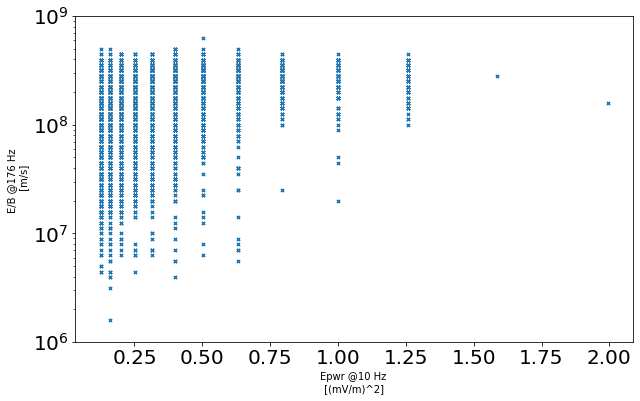

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, E_to_B_176Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel('E/B @176 Hz \n [m/s]')
plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

plt.show()

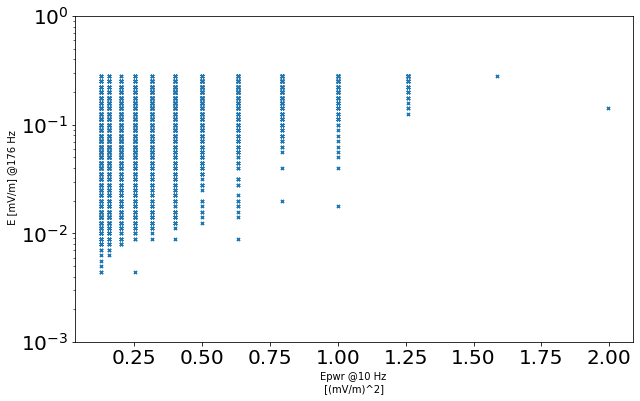

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Emax_amp_176Hz_array, s=10, marker='x')

plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel(' E [mV/m] @176 Hz')
plt.ylim(1e-3, 1)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

plt.show()

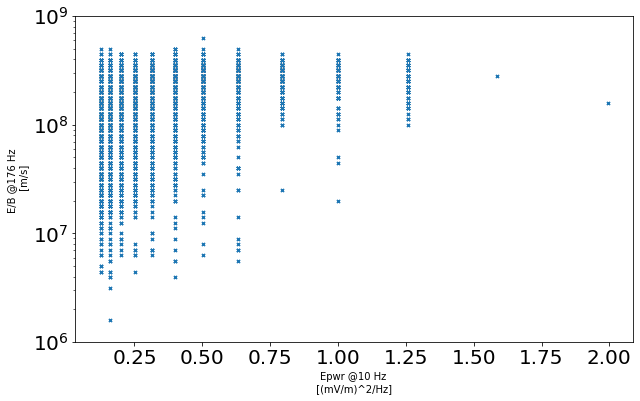

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, E_to_B_176Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2/Hz] ')
plt.ylabel('E/B @176 Hz \n [m/s]')
plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.savefig('output10')
plt.show()

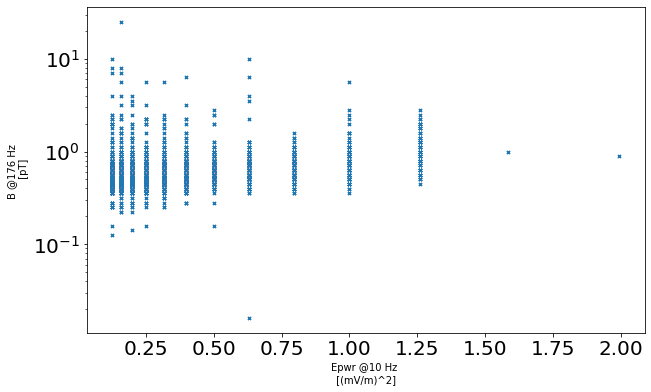

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Bmax_amp_176Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel('B @176 Hz \n [pT]')
#plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.show()

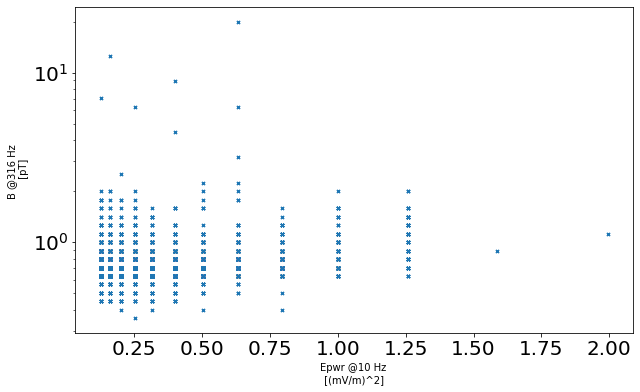

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Bmax_amp_316Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel('B @316 Hz \n [pT]')
#plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.show()

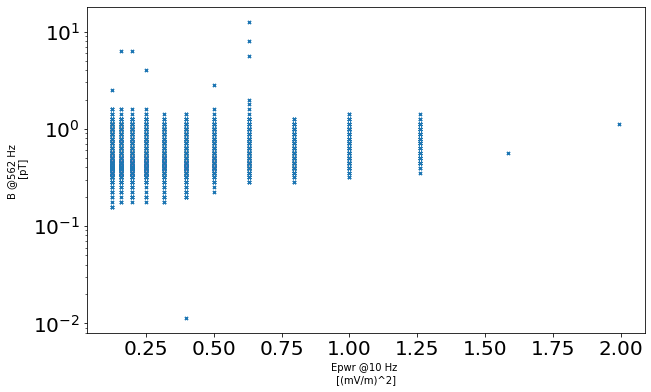

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Bmax_amp_562Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel('B @562 Hz \n [pT]')
#plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.show()

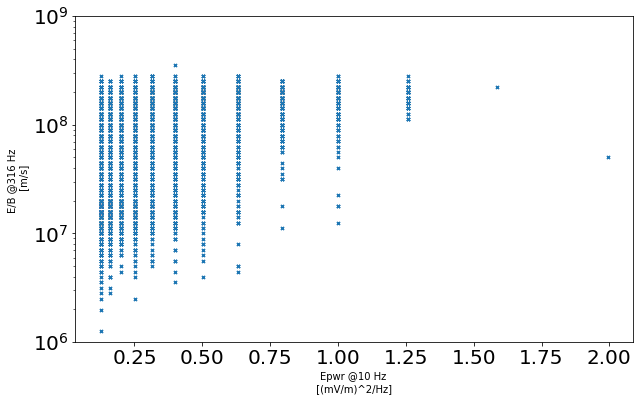

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, E_to_B_316Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2/Hz] ')
plt.ylabel('E/B @316 Hz \n [m/s]')
plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.savefig('output20')
plt.show()

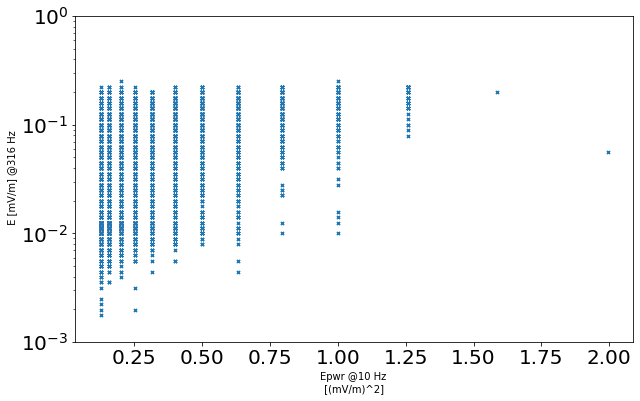

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Emax_amp_316Hz_array, s=10, marker='x')

plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel(' E [mV/m] @316 Hz')
plt.ylim(1e-3, 1)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

plt.show()

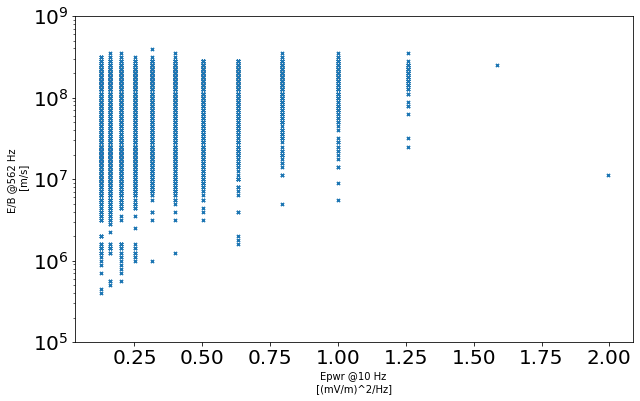

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, E_to_B_562Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2/Hz] ')
plt.ylabel('E/B @562 Hz \n [m/s]')
plt.ylim(1e5, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.savefig('output30')
plt.show()

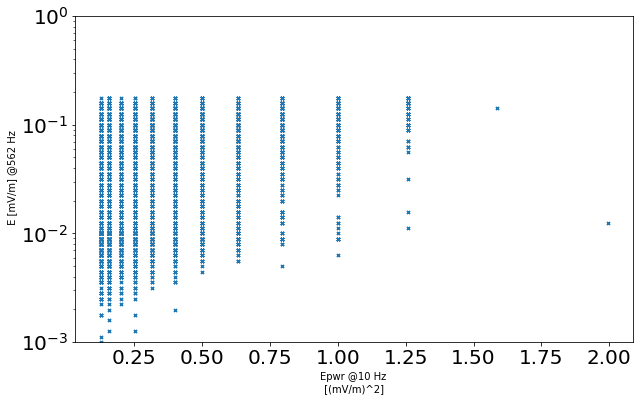

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Emax_amp_562Hz_array, s=10, marker='x')

plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel(' E [mV/m] @562 Hz')
plt.ylim(1e-3, 1)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

plt.show()

In [27]:
import numpy as np
a = np.arange(12).reshape(3,4)
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [ ]:
b = 